# Pima Indians Diabetes Classification

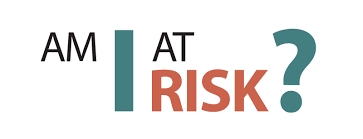

# What is Diabetes?

* Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy. Sometimes your body doesn’t make enough—or any—insulin or doesn’t use insulin well. Glucose then stays in your blood and doesn’t reach your cells.

* Over time, having too much glucose in your blood can cause health problems. Although diabetes has no cure, you can take steps to manage your diabetes and stay healthy.

* Sometimes people call diabetes “a touch of sugar” or “borderline diabetes.” These terms suggest that someone doesn’t really have diabetes or has a less serious case, but every case of diabetes is serious.

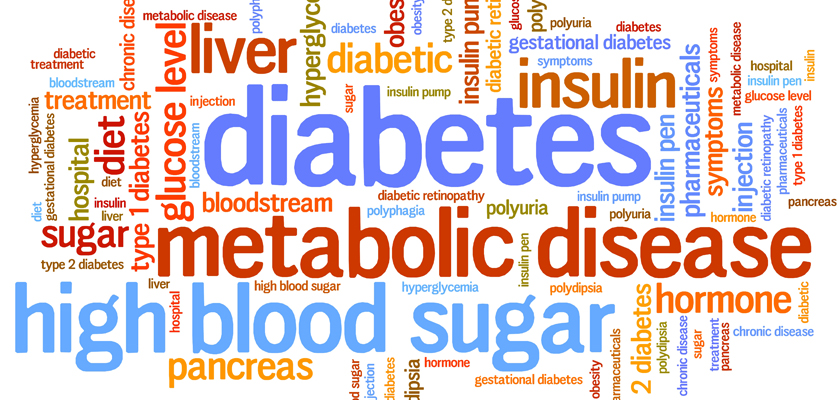

# What are the different types of diabetes?
The most common types of diabetes are type 1, type 2, and gestational diabetes.

**Type 1 diabetes**
* If you have type 1 diabetes, your body does not make insulin. Your immune system attacks and destroys the cells in your pancreas that make insulin. Type 1 diabetes is usually diagnosed in children and young adults, although it can appear at any age. People with type 1 diabetes need to take insulin every day to stay alive.

**Type 2 diabetes**
* If you have type 2 diabetes, your body does not make or use insulin well. You can develop type 2 diabetes at any age, even during childhood. However, this type of diabetes occurs most often in middle-aged and older people. Type 2 is the most common type of diabetes.

**Gestational diabetes**
* Gestational diabetes develops in some women when they are pregnant. Most of the time, this type of diabetes goes away after the baby is born. However, if you’ve had gestational diabetes, you have a greater chance of developing type 2 diabetes later in life. Sometimes diabetes diagnosed during pregnancy is actually type 2 diabetes.

# What health problems can people with diabetes develop?


**Over time, high blood glucose leads to problems such as**

* heart disease
* stroke
* kidney disease
* eye problems
* dental disease
* nerve damage
* foot problems

# Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [ ]:
df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

# Data Understanding

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1)

In [ ]:
df.describe()

* Glucose, BMI, BloodPressure, SkinThickness, Insulin ; such values cannot be expected to be 0.
* For example, having a blood pressure of 0 indicates that the person is dead.
* Therefore, it would be more correct to assign NaN instead of 0 values in the variables we chose.

In [ ]:
def info_(dataframe):
    print("shape:",dataframe.shape)
    print(dataframe.info())
    print("Index:",dataframe.index)
    print("Columns:",dataframe.columns)
    print("ANY_NAN:",dataframe.isnull().values.any())

In [ ]:
info_(df)

In [ ]:
df.skew()

In [ ]:
cat_cols = [col for col in df.columns if df[col].nunique() < 10 
                and col not in "Outcome" ]

num_cols = [col for col in df.columns if df[col].nunique() > 10
                and df[col].dtypes != "O"
                and col not in "Outcome"]

other_cols = [col for col in df.columns if col not in cat_cols 
                  and col not in num_cols and col not in "Outcome"]

In [ ]:
print("Categorical Variables : " , cat_cols)
print("Numerical Variables : " , num_cols)
print("Other Variables : " , other_cols)

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [ ]:
has_outliers(df , num_cols )

* We replaced the values we did not expect to be 0 with NaN.

In [ ]:
values_to_change = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i in values_to_change:
    df[i]=df[i].replace(0, np.NaN)


In [ ]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na

In [ ]:
missing_values_table(df)

* For the values to be given for incomplete observations, I gave the median values of the non-patients to the non-patients and the median values of the patients who were sick to the patients.

In [ ]:
def median_target(var):
    temp = df[df[var].notnull()]

    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()

    return temp

In [ ]:
columns = df.columns
columns = columns.drop("Outcome")

In [ ]:
for col in columns:
    df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = median_target(col)[col][1]

In [ ]:
def target(dataframe, target):
    f, ax = plt.subplots(1, 2, figsize=(18, 8))
    df[target].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.2f%%', ax=ax[0], shadow=True)
    ax[0].set_title(target + ' Distribution')
    ax[0].set_ylabel('')
    sns.countplot(target, data=df, ax=ax[1])
    ax[1].set_title(target + " Count Plot")
    plt.show()

# Target Analysis

In [ ]:
target(df, "Outcome")

# **# Exploratory Data Analysis**

# Correlation between variables

In [ ]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f", cmap = "icefire", figsize=(9,9))
plt.title("Correlation Between Features")
plt.show()

# Numerical Variable Analysis

In [ ]:
def pxfornum (dataframe):
    for col in dataframe[num_cols]:
        fig = px.histogram(
        df, x=col, color='Outcome',
        marginal='box', nbins=50,
        color_discrete_map={0: '#D62728', 1: '#3366CC'},
        barmode='overlay')
        fig.update_layout(height=600, width=800, 
        title_text='Diabetes Feature')
        fig.show()

In [ ]:
pxfornum(df)

# Base Models

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis = 1)

In [ ]:
log_model = LogisticRegression().fit(X,y)
y_pred = log_model.predict(X)
print("Accuracy Score:", accuracy_score(y, y_pred), "\n")
print(classification_report(y,y_pred))

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM',GradientBoostingClassifier()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))

In [ ]:
results = []
names = []

for name, model in models:
    
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Feature Importance for base Model

In [ ]:
Importance = pd.DataFrame({'Importance':LGBMClassifier().fit(X, y).feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = '#25B89B', figsize=(10,6))

plt.xlabel('LightGBM Feature Importance')
plt.gca().legend_ = None

# New Features

In [ ]:
df1 = df.copy()

# BMI

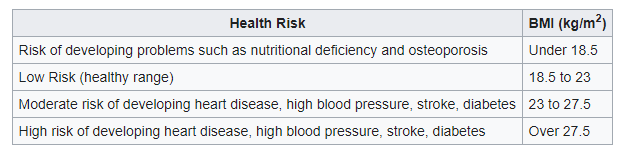

In [ ]:
df1.loc[(df1["BMI"] > 0) & (df1["BMI"] <= 18.5), "HealthRisk"] = "Underweight"
df1.loc[(df1["BMI"] > 18.5) & (df1["BMI"] <= 23), "HealthRisk"] = "Normal"
df1.loc[(df1["BMI"] > 23) & (df1["BMI"] <= 27.5), "HealthRisk"] = "Overweight"
df1.loc[(df1["BMI"] > 27.5), "HealthRisk"] = "Obese"

In [ ]:
df1['New_BMI_Skin'] = df1['BMI'] * df1['SkinThickness']
df1['New_Preg_Age'] =  df1['Pregnancies'] / df1['Age']

# Glucose

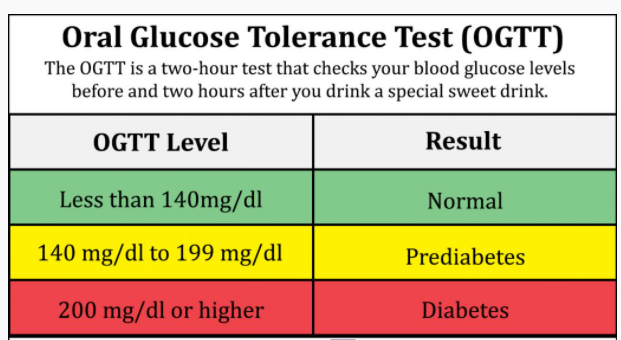

In [ ]:
df1["New_OGTT"] = pd.cut(x = df["Glucose"], bins = [0,140,200,300], labels = ["Normal","Prediabetes", "Diabetes"])

In [ ]:
df1['New_Glu_Dia'] = df1['Glucose'] / df1['DiabetesPedigreeFunction']

df1['New_Age_Dia'] = df1['Age'] * df1['DiabetesPedigreeFunction']

# Blood Pressure

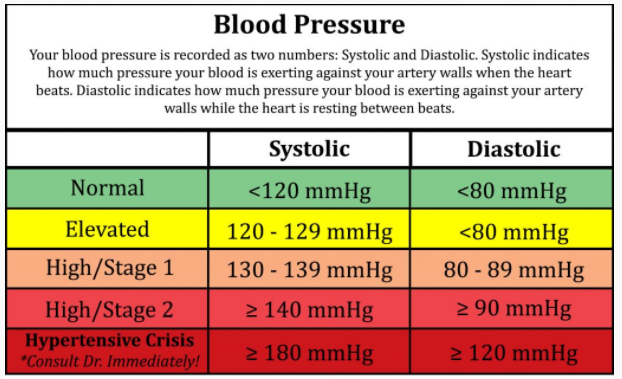

In [ ]:
df1['New_BP_Dia'] = pd.cut(x = df['BloodPressure'], bins = [0,80, 89, 120 , 123], labels = ["Normal", "High/Stage_1",  "High/Stage_2", 
                                                                                            "Hyper_Crisis"])

In [ ]:
df1['New_Age_Ins'] = df1['Age'] / df1['Insulin']


# Insulin

* 151 people with insulin levels between 160 and 179 were found to have diabetes.
* And 109 people with insulin levels between 100 and 118 were found to have not diabetes.

In [ ]:
df1.loc[(df1["Insulin"] > 0) & (df1["Insulin"] <= 99), "New_Ins_Status"] = "Abnormal"
df1.loc[(df1["Insulin"] > 99) & (df1["Insulin"] <= 118), "New_Ins_Status"] = "Normal"
df1.loc[(df1["Insulin"] > 118), "New_Ins_Status"] = "Abnormal"

In [ ]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

categorical_columns = [col for col in df1.columns
                           if len(df1[col].unique()) <= 10
                      and col != "Outcome"]

In [ ]:
df1, new_cols_ohe = one_hot_encoder(df1,categorical_columns)

In [ ]:
df1.head()

# Models

In [ ]:
X = df1.drop('Outcome', axis=1)
y = df1[["Outcome"]]

In [ ]:
models = [('RF', RandomForestClassifier()),
          ('GBM',GradientBoostingClassifier()),
          ('XGBM', XGBClassifier()),
          ("LightGBM", LGBMClassifier())]

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

**LightGBM Tuning**

In [ ]:
lgbm = LGBMClassifier(random_state=12345)
cross_val_score(lgbm, X, y, cv=10).mean()

# model tuning
lgbm_params = {"learning_rate": [0.01, 0.1, 0.5],
               "n_estimators": [500, 1000, 1500],
               "max_depth": [3, 5, 8]}

gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=2).fit(X, y)

lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X, y)
auc=cross_val_score(lgbm_tuned, X, y, cv=10).mean()
print("Auc Score : " , auc)

feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Variables importance scores')
plt.ylabel('Variables')
plt.title("Variables importance levels")
plt.show()